In [ ]:
"""
Ejercicio 1
El archivo ecg.csv contiene 5,000 latidos cardíacos provenientes del dataset "ECG5000", una colección de
datos de electrocardiograma (ECG) de "BIDMC Congestive Heart Failure Database”. Cada fila representa un
ECG completo de un paciente, compuesto por 140 puntos de datos (lecturas). Cada fila contiene una
etiqueta que indica si el ECG es normal (valor 1) o anormal (valor 0). La versión original del archivo se
encuentra en: https://www.kaggle.com/datasets/devavratatripathy/ecg-dataset


Desarrolle un modelo de autoencoder utilizando redes neuronales densas con TensorFlow/Keras que
posibilite diferenciar electrocardiogramas normales de anormales
"""

In [ ]:
"""
Ejercicio 2
Desarrolle un modelo de autoencoder que permita detectar transacciones realizadas con tarjetas de crédito
fraudulentas.
Utilice el dataset creditcard.csv provisto en la carpeta de datos del Moodle o descárguelo desde el enlace:
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud. Este presenta transacciones que ocurrieron en
dos días, donde se detectaron 492 fraudes de un total de 284,807 transacciones. Los datos están altamente
desbalanceados, ya que la clase positiva (fraudes) representa menos del 0.2% de todas las transacciones.

"""

In [1]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/My Drive/Aprendizaje Automático Profundo (AAP)/Colab Notebooks/Fuentes/'
    DATOS_DIR = '/content/drive/My Drive/Aprendizaje Automático Profundo (AAP)/Colab Notebooks/Datos/'      # carpeta donde se encuentran los datasets
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../Fuentes'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = 'D:/Datos/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)





Mounted at /content/drive/


In [2]:
# 1. LECTURA DEL SET DE DATOS
# ===============================================
import pandas as pd
import matplotlib.pyplot as plt

datos = pd.read_csv(DATOS_DIR+"creditcard.csv")
print(datos.head())

nr_clases = datos['Class'].value_counts(sort=True)
print(nr_clases)

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

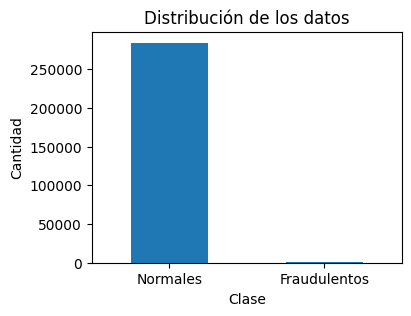

In [3]:
# 2. ANÁLISIS EXPLORATORIO DE LOS DATOS
# ===============================================

# Cantidad de registros normales vs. fraudulentos
plt.figure(figsize=(4,3))
nr_clases.plot(kind = 'bar', rot=0)
plt.xticks(range(2), ['Normales', 'Fraudulentos'])
plt.title("Distribución de los datos")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()

Cantidad de normales:  284315
Cantidad de fraudulentos:  492


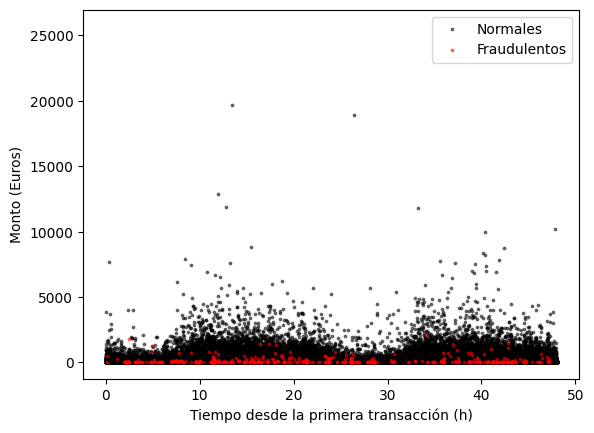

In [4]:
# Monto de las transacciones vs. tiempo
normales = datos[datos.Class==0]
fraudulentos = datos[datos.Class==1]

print('Cantidad de normales: ', len(normales))
print('Cantidad de fraudulentos: ', len(fraudulentos))

plt.scatter(normales.Time/3600, normales.Amount, alpha = 0.5, c='k', label='Normales', s=3)
plt.scatter(fraudulentos.Time/3600, fraudulentos.Amount, alpha = 0.5, c='r', label='Fraudulentos', s=3)
plt.xlabel('Tiempo desde la primera transacción (h)')
plt.ylabel('Monto (Euros)')
plt.legend(loc='upper right')
plt.show()

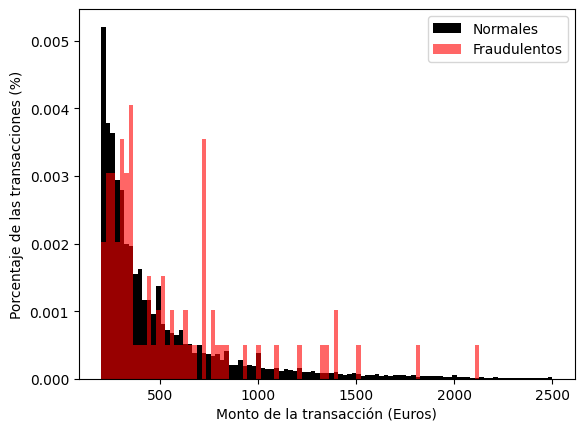

In [5]:
import numpy as np

bins = np.linspace(200, 2500, 100)
plt.hist(normales.Amount, bins, alpha=1, density=True, label='Normales', color='k')
plt.hist(fraudulentos.Amount, bins, alpha=0.6, density=True, label='Fraudulentos', color='r')
plt.legend(loc='upper right')
plt.xlabel("Monto de la transacción (Euros)")
plt.ylabel("Porcentaje de las transacciones (%)")
plt.show()

In [6]:
# 3. PRE-PROCESAMIENTO
# ===============================================

# La variable "Tiempo" no aporta información. La eliminaremos
datos.drop(['Time'], axis=1, inplace=True)


from sklearn.preprocessing import StandardScaler
datos['Amount'] = StandardScaler().fit_transform(datos['Amount'].values.reshape(-1,1))

from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(datos, test_size=0.2, random_state=42)

X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
X_train = X_train.values

Y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_test = X_test.values

print(type(X_train.shape))
print(X_train.shape)

<class 'tuple'>
(227451, 29)


In [7]:
# 4. AUTOENCODER: 29-20-14-20-29, tanh-relu-tanh-relu
# ===================================================
import numpy as np
np.random.seed(5)
from keras.models import Model, load_model
from keras.layers import Input, Dense

dim_entrada = X_train.shape[1]          # 29
capa_entrada = Input(shape=(dim_entrada,))

encoder = Dense(20, activation='tanh')(capa_entrada)
encoder = Dense(14, activation='relu')(encoder)

decoder = Dense(20, activation='tanh')(encoder)
decoder = Dense(29, activation='relu')(decoder)

autoencoder = Model(inputs=capa_entrada, outputs=decoder)

from keras.optimizers import SGD
sgd = SGD(learning_rate=0.01)
autoencoder.compile(optimizer='sgd', loss='mse')

nits = 100
tam_lote = 32
autoencoder.fit(X_train, X_train, epochs=nits, batch_size=tam_lote, shuffle=True, validation_data=(X_test,X_test), verbose=1)

Epoch 1/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 1.0133 - val_loss: 0.9172
Epoch 2/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.8595 - val_loss: 0.8503
Epoch 3/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.8167 - val_loss: 0.8235
Epoch 4/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.7837 - val_loss: 0.8026
Epoch 5/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.7541 - val_loss: 0.7662
Epoch 6/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.7262 - val_loss: 0.7454
Epoch 7/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 0.7065 - val_loss: 0.7299
Epoch 8/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.7118 - val_loss: 0.7172
Epoch 9/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - loss: 0.6969 - val_loss: 0.7089
Epoch 10/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.6731 - val_loss: 0.7023
Epoch 11/100
7108/7108 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.6754 - val_loss: 0.6964
Epoch 12

In [ ]:
#autoencoder.load_model(DATOS_DIR+'detecta_fraudes.keras')

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
(56962, 29)


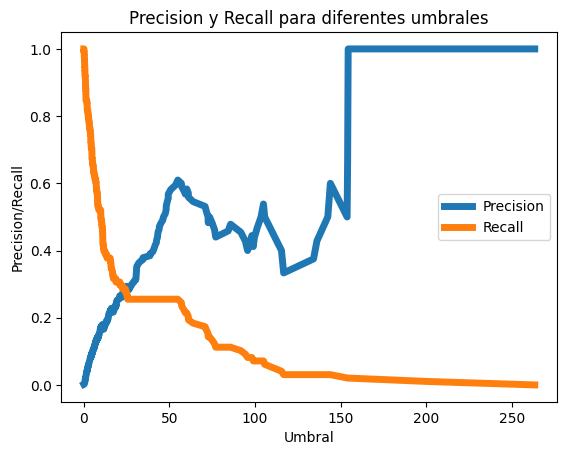

In [8]:
# 5. VALIDACIÓN
# ===============================================

# Predicción X_test -> Autoencoder -> X_pred
X_pred = autoencoder.predict(X_test)
ecm = np.mean(np.power(X_test-X_pred,2), axis=1)
print(X_pred.shape)

# Gráfica precision-recall para determinar el umbral
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report
precision, recall, umbral = precision_recall_curve(Y_test, ecm)

plt.plot(umbral, precision[1:], label="Precision",linewidth=5)
plt.plot(umbral, recall[1:], label="Recall",linewidth=5)
plt.title('Precision y Recall para diferentes umbrales')
plt.xlabel('Umbral')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [9]:
# Matriz de confusión
umbral_fijo = 0.75
Y_pred = [1 if e > umbral_fijo else 0 for e in ecm]

conf_matrix = confusion_matrix(Y_test, Y_pred)
print(conf_matrix)

report = classification_report(Y_test,Y_pred)
print("Confusion matrix Training:\n%s" % report)


[[49411  7453]
 [    8    90]]
Confusion matrix Training:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93     56864
           1       0.01      0.92      0.02        98

    accuracy                           0.87     56962
   macro avg       0.51      0.89      0.48     56962
weighted avg       1.00      0.87      0.93     56962



In [10]:
autoencoder.save(DATOS_DIR+'detecta_fraudes.keras')